# Lung Cancer Modeling #

The dataset used here is the Lung Cancer Dataset from Kaggle linked [here](https://www.kaggle.com/datasets/mysarahmadbhat/lung-cancer). The data is initially visualized, cleaned and scaled. Next, two models, a nearest neighbor model and a regularized logistic regression model are fitted to the data and the results are analyzed.

### Loading Data from Google Drive ###

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.chdir("drive/MyDrive/Lung_Project")
os.getcwd()

'/content/drive/MyDrive/Lung_Project'

The data in the CSV file is read from the Google Drive Folder and loaded into a Pandas DataFrame.

In [89]:
import pandas as pd

df = pd.read_csv("survey lung cancer.csv")
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


### Exploratory Data Analysis ###

First, the Pandas dataframe is examined to check for null values and types of data in each column

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

In [103]:
df.columns

Index(['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY',
       'PEER_PRESSURE', 'CHRONIC DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING',
       'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
       'SWALLOWING DIFFICULTY', 'CHEST PAIN', 'LUNG_CANCER'],
      dtype='object')

The trailing and leading spaces in the column names are removed.

In [104]:
df.rename(columns={'FATIGUE ': 'FATIGUE', 'ALLERGY ': 'ALLERGY'}, inplace=True)
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


Now let's consider the percentage of patients in each of the two categories: ones with lung cancer and ones without lung cancer. As seen in the bar chart, 87.38% of patients in the dataset have lung cancer and 12.62% do not, which suggests the dataset is highly imbalanced.

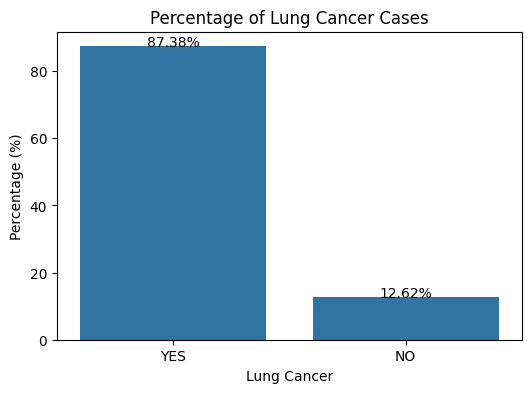

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

lung_cancer_percentages = df['LUNG_CANCER'].value_counts(normalize=True) * 100

lung_cancer_df = lung_cancer_percentages.reset_index()
lung_cancer_df.columns = ['LUNG_CANCER', 'PERCENTAGE']

plt.figure(figsize=(6, 4))
barplot = sns.barplot(x='LUNG_CANCER', y='PERCENTAGE', data=lung_cancer_df)
plt.title('Percentage of Lung Cancer Cases')
plt.xlabel('Lung Cancer')
plt.ylabel('Percentage (%)')

for index, row in lung_cancer_df.iterrows():
    barplot.text(row.name, row.PERCENTAGE, f'{round(row.PERCENTAGE, 2)}%',
                 color='black', ha="center")

plt.show()

Let's find variables that might be most important in prediction

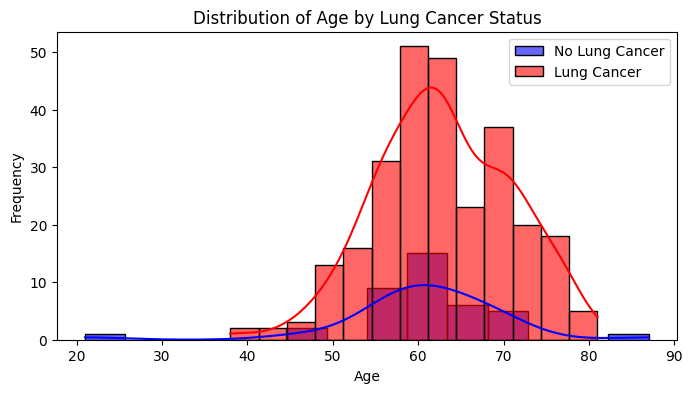

In [106]:
plt.figure(figsize=(8, 4))

sns.histplot(data=df[df['LUNG_CANCER'] == 'NO'], x='AGE', color='blue',
            label='No Lung Cancer', kde=True, alpha=0.6)

sns.histplot(data=df[df['LUNG_CANCER'] == 'YES'], x='AGE', color='red',
             label='Lung Cancer', kde=True, alpha=0.6)

plt.title('Distribution of Age by Lung Cancer Status')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

plt.show()

The histograms mostly overlap between lung cancer patients and others, which suggests age is not a good predictor

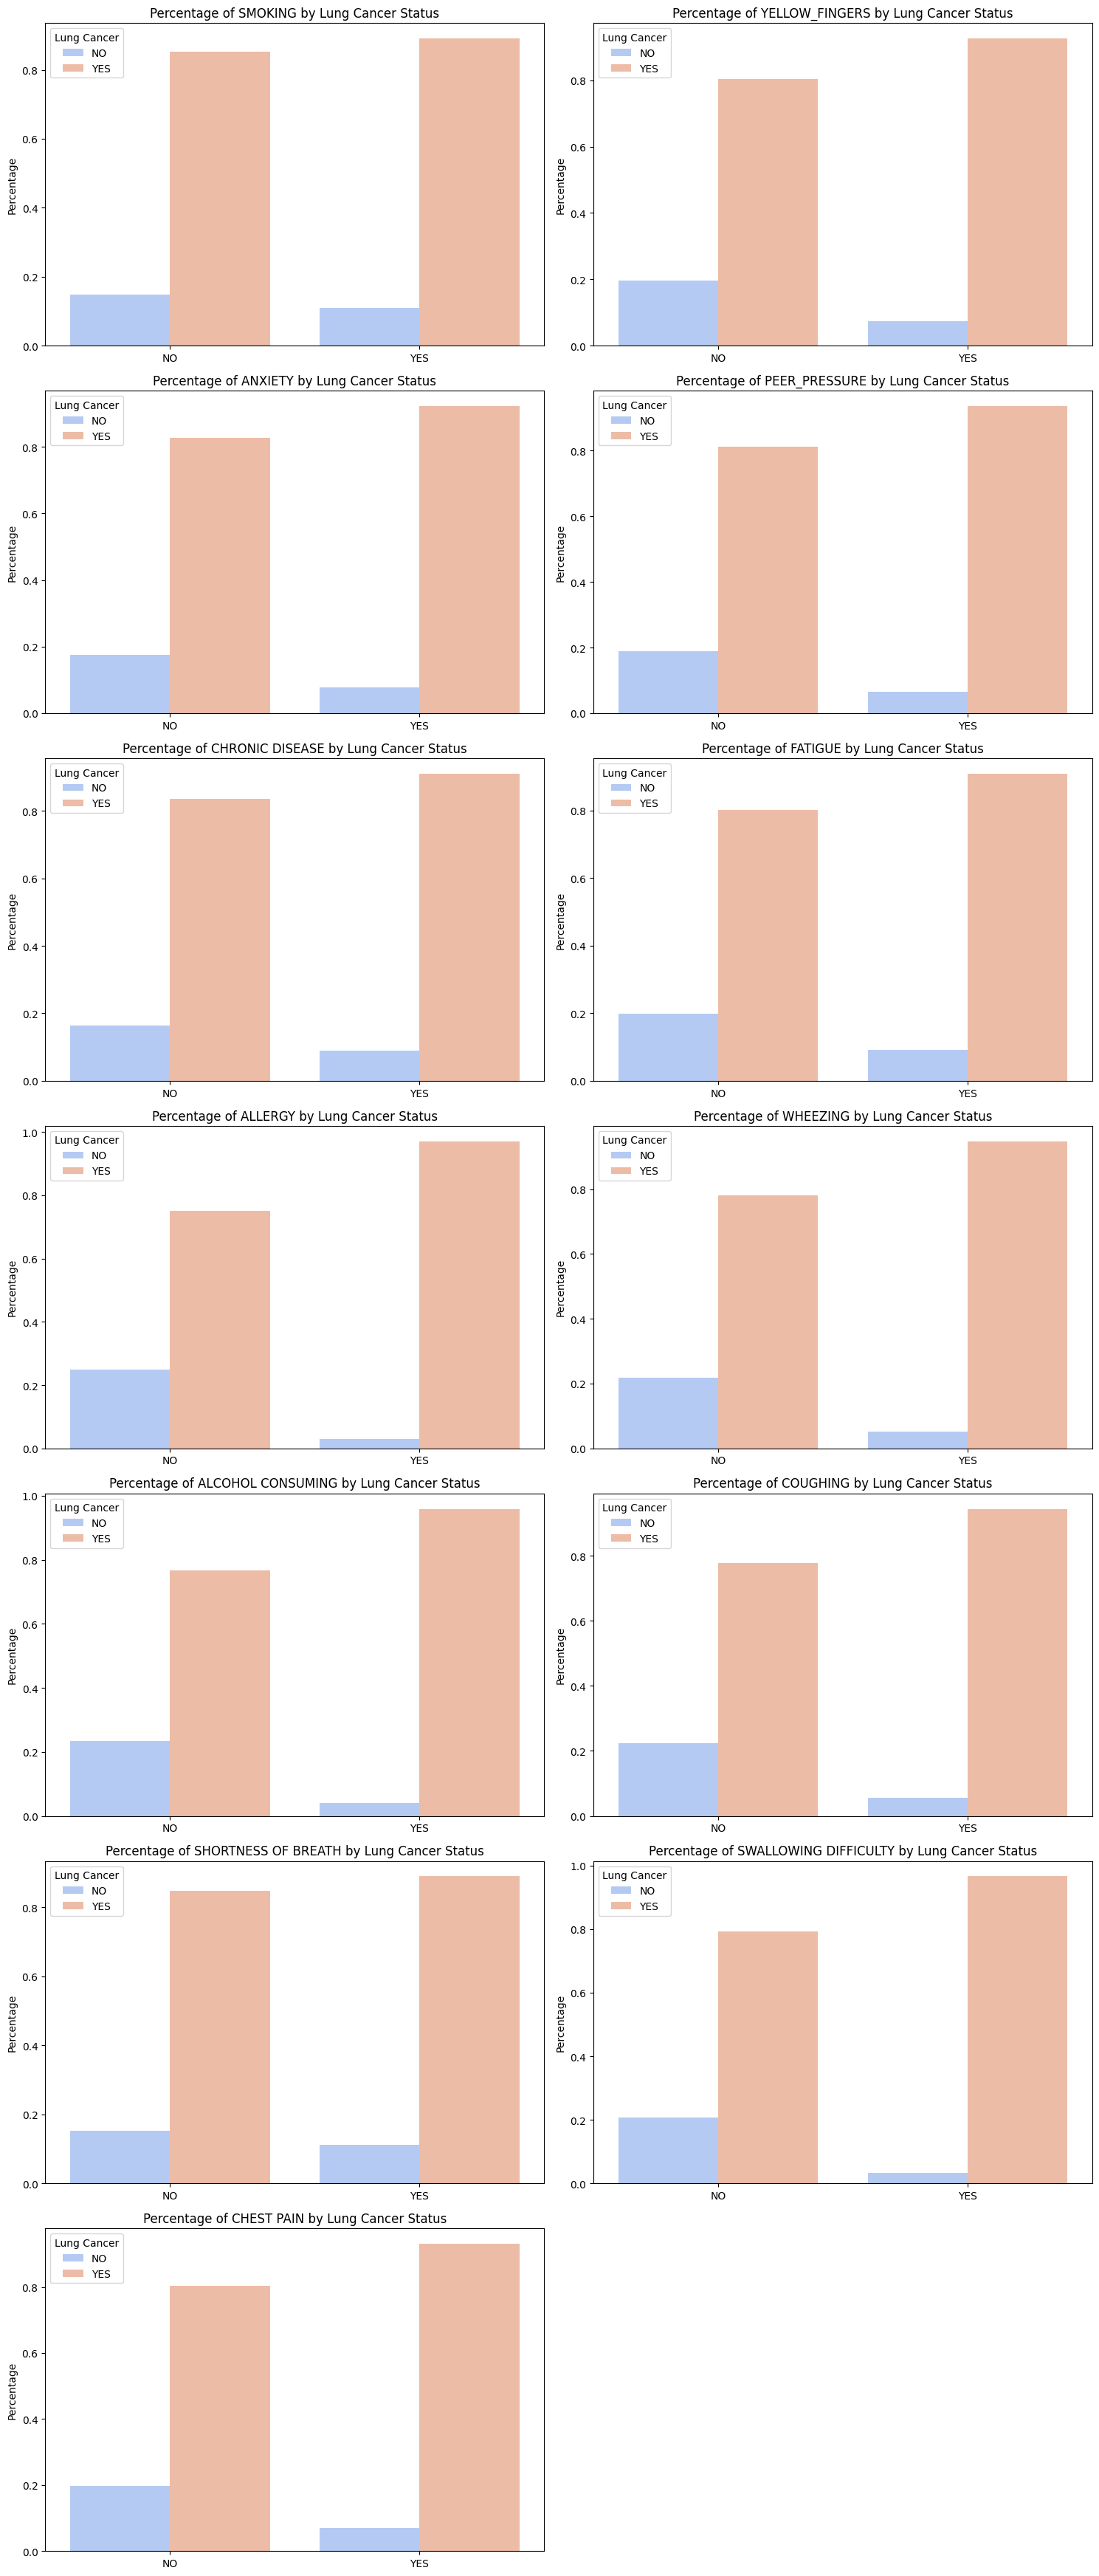

In [107]:
binary_variables = ['SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE',
                    'CHRONIC DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING',
                    'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
                    'SWALLOWING DIFFICULTY', 'CHEST PAIN']

binary_mapping = {1: 'NO', 2: 'YES'}

num_rows = (len(binary_variables) + 1) // 2
plt.figure(figsize=(15, num_rows * 5))


for i, variable in enumerate(binary_variables):
    plt.subplot(num_rows, 2, i + 1)

    temp_df = df.copy()
    temp_df[variable] = temp_df[variable].map(binary_mapping)
    total = temp_df.groupby(variable)['LUNG_CANCER'].count()
    percentage_df = (temp_df.groupby([variable, 'LUNG_CANCER']).size()
     / total).reset_index(name='percentage')

    sns.barplot(x=variable, y='percentage', hue='LUNG_CANCER',
                data=percentage_df, palette='coolwarm')
    plt.title(f'Percentage of {variable} by Lung Cancer Status')
    plt.ylabel('Percentage')
    plt.xlabel('')
    plt.legend(title='Lung Cancer')

plt.tight_layout()
plt.show()

The bar charts above suggest that some good indicator for lung cancer are chest pain, swallowing difficulty, coughing, alcohol consumption, and fatigue since the distribution for these vary the most between the two categories. By contrast, shortness of breath and smoking are (counterintuitively!) weak predictors since the distributions for these is rather similar between those with and those without lung cancer.

Finally, to prepare the data for the models later, we map binary variables to 0 and 1, and scale the age variable with a normal distribution.

In [108]:
from sklearn.preprocessing import StandardScaler

df['GENDER'] = df['GENDER'].map({'M': 1, 'F': 0})
df['LUNG_CANCER'] = df['LUNG_CANCER'].map({'NO': 1, 'YES': 0})

cat_list = ['SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE',
            'CHRONIC DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING',
            'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
            'SWALLOWING DIFFICULTY', 'CHEST PAIN']

for c in cat_list:
  df[c] = df[c].map({1: 0, 2: 1})

scaler = StandardScaler()

df['AGE'] = scaler.fit_transform(df['AGE'].values.reshape(-1, 1))
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,0.771850,0,1,1,0,0,1,0,1,1,1,1,1,1,0
1,1,1.381829,1,0,0,0,1,1,1,0,0,0,1,1,1,0
2,0,-0.448107,0,0,0,1,0,1,0,1,0,1,1,0,1,1
3,1,0.039876,1,1,1,0,0,0,0,0,1,0,0,1,1,1
4,0,0.039876,0,1,0,0,0,0,0,1,0,1,1,0,0,1


In [109]:
X = df.drop(columns='LUNG_CANCER')
y = df['LUNG_CANCER']

### Fitting a Nearest Neighbor Classifier ###

The k-NN model is fitted below. There are three hyperparameters that are randomly assigned for 30 iterations: the number of neighbors, the metric for neighbor distance, and the assignment weights. Random search is used to identify 30 combinations of hyperparameters and evaulate the model performance using 10-fold cross-validation. The cross-validation is particularly importance since the dataset is really small making any model potentially unstable. Each time a model exceeds the highest accuracy seen so far, the weights, the model, and its parameters are saved

In [84]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score

n_neighbors = range(1, 31)
weights = ['uniform', 'distance']
metrics = ['euclidean', 'manhattan', 'minkowski']

k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

best_k_nn_model = None
best_k_nn_accuracy = 0
best_k_nn_params = {}

for i in range(30):
    random_n_neighbors = np.random.choice(n_neighbors)
    random_weights = np.random.choice(weights)
    random_metric = np.random.choice(metrics)

    knn = KNeighborsClassifier(n_neighbors=random_n_neighbors,
                               weights=random_weights,
                               metric=random_metric)

    scores = cross_val_score(knn, X, y, cv=kf, scoring='accuracy')
    accuracy = np.mean(scores)

    print(f"Iteration {i+1}:")
    print(f"n_neighbors = {random_n_neighbors}, ",
          f"weights = {random_weights}, ",
          f"metric = {random_metric}")
    print(f"Cross-validation Accuracy = {round(accuracy, 4)}\n")

    if accuracy > best_k_nn_accuracy:
        best_k_nn_accuracy = accuracy
        best_k_nn_model = knn
        best_k_nn_params = {
            'n_neighbors': random_n_neighbors,
            'weights': random_weights,
            'metric': random_metric
        }

print("Best model parameters:", best_k_nn_params)
print("Best model cross-validation accuracy:", best_k_nn_accuracy)

Iteration 1:
n_neighbors = 16,  weights = uniform,  metric = manhattan
Cross-validation Accuracy = 0.8773

Iteration 2:
n_neighbors = 2,  weights = uniform,  metric = minkowski
Cross-validation Accuracy = 0.8837

Iteration 3:
n_neighbors = 27,  weights = distance,  metric = euclidean
Cross-validation Accuracy = 0.8837

Iteration 4:
n_neighbors = 12,  weights = distance,  metric = euclidean
Cross-validation Accuracy = 0.8998

Iteration 5:
n_neighbors = 18,  weights = uniform,  metric = euclidean
Cross-validation Accuracy = 0.8741

Iteration 6:
n_neighbors = 5,  weights = distance,  metric = minkowski
Cross-validation Accuracy = 0.8998

Iteration 7:
n_neighbors = 16,  weights = uniform,  metric = euclidean
Cross-validation Accuracy = 0.8709

Iteration 8:
n_neighbors = 4,  weights = distance,  metric = manhattan
Cross-validation Accuracy = 0.9127

Iteration 9:
n_neighbors = 12,  weights = distance,  metric = minkowski
Cross-validation Accuracy = 0.8998

Iteration 10:
n_neighbors = 10,  we

### Fitting a Logistic Regression Model ###

Similar to k-NN, logistic regression is fitted below with two hyperparameters, regularization type (L1 or L2 distance), and regularization parameter assigned using random search. Since the dataset is small, logistic regression could easily overfit which is why regularization is so crucial. Since logistic regression is a parametric method unlike k-NN, the importance of each feature can be better understood based on the chosen model so feature importances are saved for the best model as well.

In [85]:
from sklearn.linear_model import LogisticRegression

C_values = np.logspace(-4, 4, 20)
penalties = ['l1', 'l2']

k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

best_log_reg_model = None
best_log_reg_accuracy = 0
best_log_reg_params = {}

for i in range(30):
    random_C = np.random.choice(C_values)
    random_penalty = np.random.choice(penalties)

    lr = LogisticRegression(C=random_C, penalty=random_penalty,
                            solver='liblinear', random_state=42)

    scores = cross_val_score(lr, X, y, cv=kf, scoring='accuracy')
    accuracy = np.mean(scores)

    print(f"Iteration {i+1}:")
    print(f"C = {random_C}, penalty = {random_penalty}")
    print(f"Cross-validation Accuracy = {round(accuracy, 4)}\n")

    if accuracy > best_log_reg_accuracy:
        best_log_reg_accuracy = accuracy
        best_log_reg_model = lr
        best_log_reg_params = {'C': random_C, 'penalty': random_penalty}

print("Best model parameters:", best_log_reg_params)
print("Best model cross-validation accuracy:", best_log_reg_accuracy)

Iteration 1:
C = 206.913808111479, penalty = l1
Cross-validation Accuracy = 0.9354

Iteration 2:
C = 4.281332398719396, penalty = l1
Cross-validation Accuracy = 0.9289

Iteration 3:
C = 78.47599703514607, penalty = l2
Cross-validation Accuracy = 0.9354

Iteration 4:
C = 1438.44988828766, penalty = l1
Cross-validation Accuracy = 0.9354

Iteration 5:
C = 0.012742749857031334, penalty = l2
Cross-validation Accuracy = 0.8741

Iteration 6:
C = 11.288378916846883, penalty = l2
Cross-validation Accuracy = 0.9289

Iteration 7:
C = 10000.0, penalty = l1
Cross-validation Accuracy = 0.9354

Iteration 8:
C = 0.004832930238571752, penalty = l2
Cross-validation Accuracy = 0.8741

Iteration 9:
C = 1.623776739188721, penalty = l1
Cross-validation Accuracy = 0.9225

Iteration 10:
C = 78.47599703514607, penalty = l2
Cross-validation Accuracy = 0.9354

Iteration 11:
C = 3792.690190732246, penalty = l2
Cross-validation Accuracy = 0.9354

Iteration 12:
C = 3792.690190732246, penalty = l1
Cross-validation A

The bar chart shows the importance of each variable in predictions of the best model. Based on the results, coughing, chronic disease, fatigue, and swallowing difficulty are the most important predictors while age is the least significant.

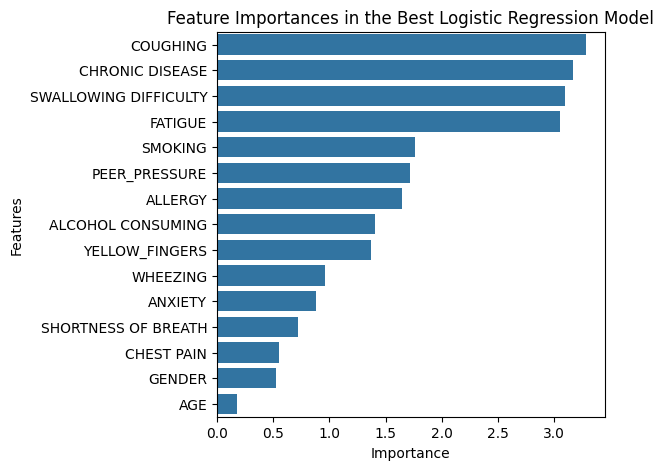

In [86]:
best_log_reg_model.fit(X, y)
best_feat_imps = sorted(list(zip(X.columns,
                                 np.abs(best_log_reg_model.coef_[0]))),
                                 key=lambda x: x[1], reverse=True)

features, importances = zip(*best_feat_imps)

plt.figure(figsize=(5, 5))
sns.barplot(x=list(importances), y=list(features))
plt.title('Feature Importances in the Best Logistic Regression Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Some of the observations in the exploratory data analysis section are confirmed by the bar plot above. For example, as seen in the EDA section, distributions for age are largely overlapping, making it a bad variable for prediction lung cancer. That observation is confirmed by the feature importances since the age weight is very small. The EDA section also showed very different distributions between the two classes for coughing and swallowing difficulty. The importance of these two variables is confirmed by the high absolute value of their coefficients in the logistic regression model.

### Fitting a Support Vector Machine Model ###

The third and final model fitted is SVMs with three hyperparameters, kernel type (choice between standard SVM, and kernel SVM with a polynomial or a Radial Basis Kernel), regularization parameter C, and Kernel parameter gamma, with the latter two being extremely important for avoiding overfitting. Like Logistic Regression, SVM is a parametric method, allowing for the importance of each feature to be visualized and examined.

In [112]:
from sklearn.svm import SVC

C_values = np.logspace(-4, 4, 20)
kernels = ['linear', 'rbf', 'poly']
gammas = np.logspace(-9, 3, 13)

k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

best_svm_model = None
best_svm_accuracy = 0
best_svm_params = {}

for i in range(30):
    random_C = np.random.choice(C_values)
    random_kernel = np.random.choice(kernels)
    random_gamma = np.random.choice(gammas) if \
    random_kernel != 'linear' else 'auto'

    svm = SVC(C=random_C, kernel=random_kernel,
              gamma=random_gamma, random_state=42)

    scores = cross_val_score(svm, X, y, cv=kf, scoring='accuracy')
    accuracy = np.mean(scores)

    print(f"Iteration {i+1}:")
    print(f"C = {random_C}, ",
          f"Kernel = {random_kernel}, ",
          f"Gamma = {random_gamma}")
    print(f"Cross-validation Accuracy = {round(accuracy, 4)}\n")

    if accuracy > best_svm_accuracy:
        best_svm_accuracy = accuracy
        best_svm_model = svm
        best_svm_params = {'C': random_C, 'kernel': random_kernel,
                           'gamma': random_gamma}

print("Best model parameters:", best_svm_params)
print("Best model cross-validation accuracy:", best_svm_accuracy)

Iteration 1:
C = 206.913808111479, Kernel = poly, Gamma = 0.001
Cross-validation Accuracy = 0.8741

Iteration 2:
C = 0.004832930238571752, Kernel = linear, Gamma = auto
Cross-validation Accuracy = 0.8741

Iteration 3:
C = 0.615848211066026, Kernel = rbf, Gamma = 1000.0
Cross-validation Accuracy = 0.8741

Iteration 4:
C = 3792.690190732246, Kernel = poly, Gamma = 0.001
Cross-validation Accuracy = 0.8741

Iteration 5:
C = 78.47599703514607, Kernel = rbf, Gamma = 1e-05
Cross-validation Accuracy = 0.8741

Iteration 6:
C = 0.004832930238571752, Kernel = rbf, Gamma = 1000.0
Cross-validation Accuracy = 0.8741

Iteration 7:
C = 0.00026366508987303583, Kernel = rbf, Gamma = 0.001
Cross-validation Accuracy = 0.8741

Iteration 8:
C = 0.615848211066026, Kernel = poly, Gamma = 1e-09
Cross-validation Accuracy = 0.8741

Iteration 9:
C = 0.012742749857031334, Kernel = rbf, Gamma = 1e-05
Cross-validation Accuracy = 0.8741

Iteration 10:
C = 0.004832930238571752, Kernel = poly, Gamma = 1.0
Cross-validat

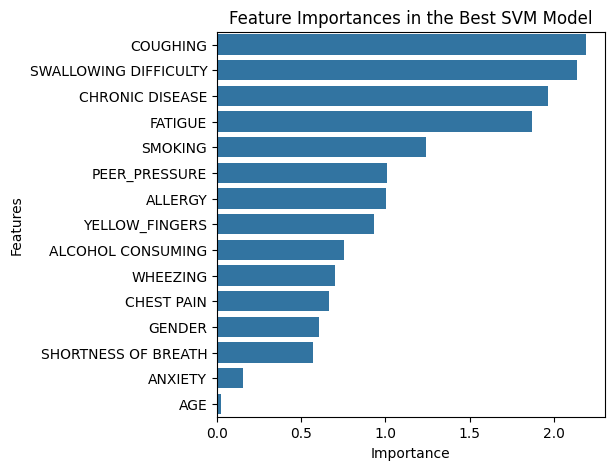

In [113]:
best_svm_model.fit(X, y)
best_feat_imps = sorted(list(zip(X.columns,
                           np.abs(best_svm_model.coef_[0]))),
                           key=lambda x: x[1], reverse=True)

features, importances = zip(*best_feat_imps)

plt.figure(figsize=(5, 5))
sns.barplot(x=list(importances), y=list(features))
plt.title('Feature Importances in the Best SVM Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

### Comparison of Models ###

The models can be compared on the basis of testing accuracy. In that case, Regularized Logistic Regression is the best model with an averaged 93.54% across folds, followed by 91.92% for SVM and 91.27% for k-NN. Logistic Regression and SVM are also better than k-NN because they allow for feature importance.